In [85]:
import ee
%matplotlib inline
import math
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

import datetime, calendar

plt.style.use("seaborn-darkgrid")

ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1Adeu5BXBkkXxDSSqK-_jsFkdPRDfabF7rbf_5_OuQHv-G9JPvYm2WWihFaI

Successfully saved authorization token.


In [86]:
MODEL_INFO = {'UKESM1-0-LL': 'HadAM',
 'NorESM2-MM': 'CCM',
 'NorESM2-LM': 'CCM',
 'MRI-ESM2-0': 'UCLA GCM',
 'MPI-ESM1-2-LR': 'ECMWF',
 'MPI-ESM1-2-HR': 'ECMWF',
 'MIROC6': 'MIROC',
 'MIROC-ES2L': 'MIROC',
 'KIOST-ESM': 'GFDL',
 'KACE-1-0-G': 'HadAM',
 'IPSL-CM6A-LR': 'IPSL',
 'INM-CM5-0': 'INM',
 'INM-CM4-8': 'INM',
 'HadGEM3-GC31-MM': 'HadAM',
 'HadGEM3-GC31-LL': 'HadAM',
 'GFDL-ESM4': 'GFDL',
 'GFDL-CM4_gr2': 'GFDL',
 'GFDL-CM4': 'GFDL',
 'FGOALS-g3': 'CCM',
 'EC-Earth3-Veg-LR': 'ECMWF',
 'EC-Earth3': 'ECMWF',
 'CanESM5': 'CanAM',
 'CNRM-ESM2-1': 'ECMWF',
 'CNRM-CM6-1': 'ECMWF',
 'CMCC-ESM2': 'CCM',
 'CMCC-CM2-SR5': 'CCM',
 'BCC-CSM2-MR': 'CCM',
 'ACCESS-ESM1-5': 'HadAM',
 'ACCESS-CM2': 'HadAM',
 'TaiESM1': 'CCM',
}

EXCLUDED_MODELS = ['GFDL-CM4_gr2','ERA5']    # TaiESM1 model has major known biases

MODELS = [i for i in MODEL_INFO if not i in EXCLUDED_MODELS]

SEASONS = [
    ('12-01', '02-28'),
    ('03-01'), ('05-31'),
    ('06-01'), ('08-31'),
    ('09-01'), ('11-30')
]

INITIAL_LATLON = (22.5276, 88.3639)  # Kolkata
INITIAL_WINDOW = ('04-15', '11-30')

HIST_START = 1980
HIST_END = 2014
FUTURE_START = 2050
FUTURE_END = 2070

STUDY_THRESH = 40

NUM_BEST_MODELS = 3

In [87]:
def d2j(datestring):
    d = datetime.date.fromisoformat(datestring)
    jday = d.timetuple().tm_yday
    if calendar.isleap(d.year) and jday > 59:
        jday -= 1
    return jday

In [88]:
def get_var(varname, model, latlon, start_year=HIST_START, end_year=HIST_END, yearshift=False, scenario='ssp585'):
    def removeLeapDays(arr, yearshift=False):
        if not yearshift:
            indices = []
            jan1_idx = 0
            for year in range(start_year, end_year+1):
                indices += [jan1_idx + i for i in range(365)]
                jan1_idx += 365
                if calendar.isleap(year):
                    jan1_idx += 1
            return arr[indices]
        else:
            indices = []
            jul1_idx = 0
            for year in range(start_year-1, end_year):
                indices += [jul1_idx + i for i in range(183)]
                jul1_idx += 183
                if calendar.isleap(year):
                    jul1_idx += 1
                indices += [jul1_idx + i for i in range(182)]
                jul1_idx += 182
            return arr[indices]
    if model != 'ERA5' and start_year < 2015 and end_year >= 2015:
        raise Exception("Requesting hist and non-hist variables in one query")
    if model == 'ERA5':
        dataset = ee.ImageCollection("ECMWF/ERA5/DAILY")
    else:
        dataset = ee.ImageCollection('NASA/GDDP-CMIP6').filter(ee.Filter.eq('model', model)).filter(ee.Filter.eq('scenario', [scenario, 'historical'][int(end_year<2015)]))
    gee_geom = ee.Geometry.Point((latlon[1], latlon[0]))
    if not yearshift:
        data_vars = dataset.select(varname).filter(ee.Filter.date('{0}-01-01'.format(start_year), '{0}-01-01'.format(end_year+ 1)))
        result = [i[4] for i in data_vars.getRegion(gee_geom, 2500, 'epsg:4326').getInfo()[1:]]
        return removeLeapDays(np.array(result), False)
    else:
        data_vars = dataset.select(varname).filter(ee.Filter.date('{0}-07-01'.format(start_year-1), '{0}-07-01'.format(end_year)))
        result = [i[4] for i in data_vars.getRegion(gee_geom, 2500, 'epsg:4326').getInfo()[1:]]
        return removeLeapDays(np.array(result), True)

In [89]:
def get_rmsd(d1, d2):
    def seasonal_means(d):
        mam = []  # 60-151
        jja = []  # 152-243
        son = []  # 244-334
        djf = []  # 335-59
        jan1_idx = 365 + [0, 1][int(calendar.isleap(HIST_START))]
        for year in range(HIST_START+1, HIST_END):
            mam.append(d[jan1_idx + 60 : jan1_idx + 152])
            jja.append(d[jan1_idx + 152 : jan1_idx + 244])
            son.append(d[jan1_idx + 244 : jan1_idx + 335])
            if year < HIST_END - 1:
                if False and calendar.isleap(year):
                    yearlength = 366
                else:
                    yearlength = 365
                djf.append(np.concatenate((d[jan1_idx + 335 : jan1_idx + 365], d[jan1_idx + yearlength : jan1_idx + yearlength + 60])))
            else:
                djf.append(np.concatenate((d[335 : 365], d[365 + [0, 1][int(False and calendar.isleap(HIST_START))] : 425])))
            jan1_idx += 365 + [0, 1][int(False and calendar.isleap(year))]
        return np.array([np.mean(mam, axis=1), np.mean(jja, axis=1), np.mean(son, axis=1), np.mean(djf, axis=1)]).flatten()
            
    c1 = seasonal_means(d1)
    c2 = seasonal_means(d2)
    return np.sqrt(np.mean(np.sum((c1 - c2)**2)))

In [90]:
def calibration_function(hist_obs, hist_mod):
    source = np.sort(hist_obs.flatten())
    target= np.sort(hist_mod.flatten())
    if (np.max(source) == 0 and np.min(source) == 0):
        return np.arange(0, target.size) / target.size
    if (np.max(target) == 0 and np.min(target) == 0):
        return np.arange(0, source.size) / source.size
    new_indices = []
    #source[-1] = target[-1]  # when target[i] greater than all source values, return max index
    for target_idx, target_value in enumerate(target):
        if target_idx < len(source):
            source_value = source[target_idx]
            if source_value > target[-1]:
                new_indices.append(target.size - 1)
            else:
                new_indices.append(np.argmax(target >= source_value))
    return np.array(new_indices) / source.size

def calibrate(uncalibrated_data, calibration_fxn):
    N = len(uncalibrated_data)
    unsorted_uncalib = [(i, idx) for idx, i in enumerate(uncalibrated_data)]
    sorted_uncalib = sorted(unsorted_uncalib)
    result = [0] * N
    for j in range(N):
        X_j = j / (N + 1)
        Y_jprime = calibration_fxn[round(X_j * len(calibration_fxn))]
        jprime = math.floor(Y_jprime * N + 1)
        result[sorted_uncalib[j][1]] = sorted_uncalib[jprime][0]
    return result

In [91]:
# Select three best models based on RMSD of quarterly mean tasmax
hist_obs = get_var('maximum_2m_air_temperature', 'ERA5', INITIAL_LATLON)
hist_mods = {}
rmsds = []
for model in MODELS:
    hist_mod = get_var('tasmax', model, INITIAL_LATLON, start_year=HIST_START-1)
    hist_mods[model] = hist_mod
    rmsds.append((get_rmsd(hist_obs, hist_mod), model))
rmsds.sort()
best_models = []
families = []
idx = 0
while len(best_models) < 3:
    if not MODEL_INFO[rmsds[idx][1]] in families:
        best_models.append(rmsds[idx][1])
        families.append(MODEL_INFO[rmsds[idx][1]])
    idx += 1
    
for m in best_models:
    print(m, [i[0] for i in rmsds if i[1]==m][0])

NorESM2-LM 15.604376533370058
ACCESS-ESM1-5 15.877571315517939
MIROC-ES2L 15.987326373101315


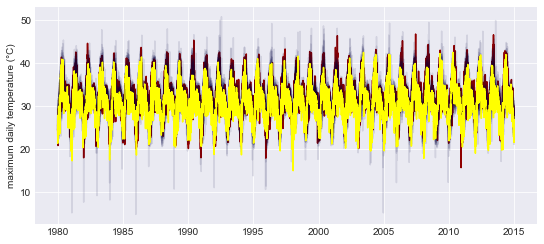

In [18]:
plt.figure(figsize=(9, 4))
for model in hist_mods:
    plt.plot([1980 + (i/365) for i in list(range(len(hist_obs)))], hist_mods[model][:len(hist_obs)] - 273.15, color=['#000040', '#900000'][int(model in best_models)], alpha=[0.1, 1][int(model in best_models)])
    #plt.xlabel('modeled')
    plt.ylabel('maximum daily temperature (°C)')
    #plt.legend()
plt.plot([1980 + (i/365) for i in list(range(len(hist_obs)))], hist_obs - 273.15, color="#ffff00")
plt.show()

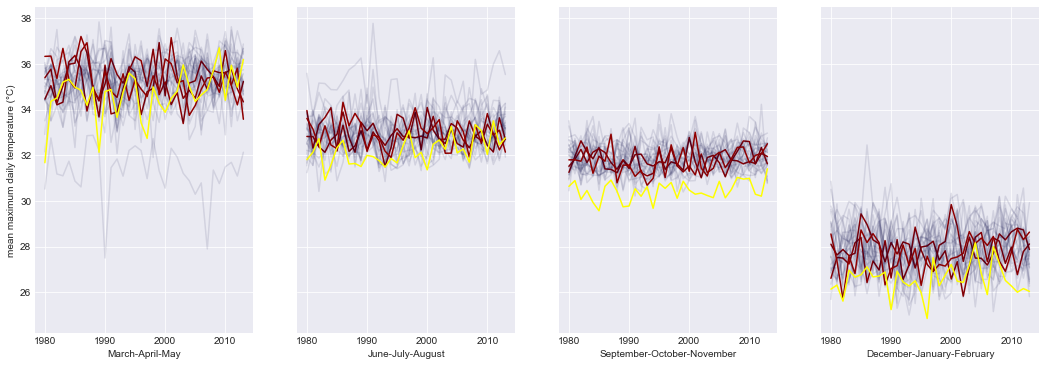

<Figure size 648x288 with 0 Axes>

In [93]:
def seasonal_means(d):
    def the_seasonal_means(d):
        mam = []  # 60-151
        jja = []  # 152-243
        son = []  # 244-334
        djf = []  # 335-59
        jan1_idx = 365 + [0, 1][int(calendar.isleap(HIST_START))]
        for year in range(HIST_START, HIST_END):
            mam.append(d[jan1_idx + 60 : jan1_idx + 152])
            jja.append(d[jan1_idx + 152 : jan1_idx + 244])
            son.append(d[jan1_idx + 244 : jan1_idx + 335])
            if year < HIST_END - 1:
                if calendar.isleap(year) and False:
                    yearlength = 366
                else:
                    yearlength = 365
                djf.append(np.concatenate((d[jan1_idx + 335 : jan1_idx + 365], d[jan1_idx + yearlength : jan1_idx + yearlength + 60])))
            else:
                djf.append(np.concatenate((d[335 : 365], d[365 + [0, 1][int(False and calendar.isleap(HIST_START-1))] : 425])))
            jan1_idx += 365 + [0, 1][int(False and calendar.isleap(year))]
        return np.array([np.mean(mam, axis=1), np.mean(jja, axis=1), np.mean(son, axis=1), np.mean(djf, axis=1)])

    return the_seasonal_means(d)
fig, (mam, jja, son, djf) = plt.subplots(1, 4, sharey=True, figsize=(18, 6))
plt.figure(figsize=(9,4))
for season in range(4):
    ax = [mam, jja, son, djf][season]
    for model in hist_mods:
        ax.plot([HIST_START + i for i in range(HIST_END - HIST_START)], seasonal_means(hist_mods[model] - 273.15)[season], color=['#000040', '#900000'][int(model in best_models)], alpha=[0.1, 1][int(model in best_models)])
    ax.plot([HIST_START + i for i in range(HIST_END - HIST_START)], seasonal_means(hist_obs - 273.15)[season], color="#ffff00")
    if season == 0:
        ax.set_ylabel('mean maximum daily temperature (°C)')
    ax.set_xlabel(['March-April-May', 'June-July-August', 'September-October-November', 'December-January-February'][season])
        #plt.xlabel('modeled')
    #plt.legend()


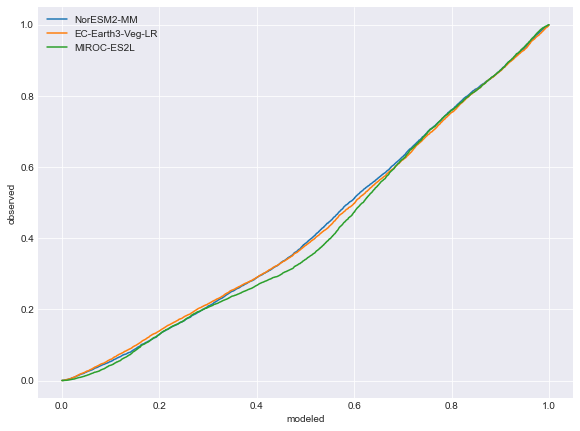

In [24]:
# Get tasmax calibration functions

calibration_fxn = {}
hist_mod = {}

hist_obs = get_var('maximum_2m_air_temperature', 'ERA5', INITIAL_LATLON)
plt.figure(figsize=(6.4*1.5, 4.8*1.5))
for model in ['NorESM2-MM', 'EC-Earth3-Veg-LR', 'MIROC-ES2L']:
    hist_mod[model] = get_var('tasmax', model, INITIAL_LATLON)
    calibration_fxn[model] = calibration_function(hist_obs, hist_mod[model])
    plt.plot([j/(len(hist_obs)+1) for j in range(len(hist_obs))], calibration_fxn[model], label=model)
    plt.xlabel('modeled')
    plt.ylabel('observed')
    plt.legend()
plt.show()

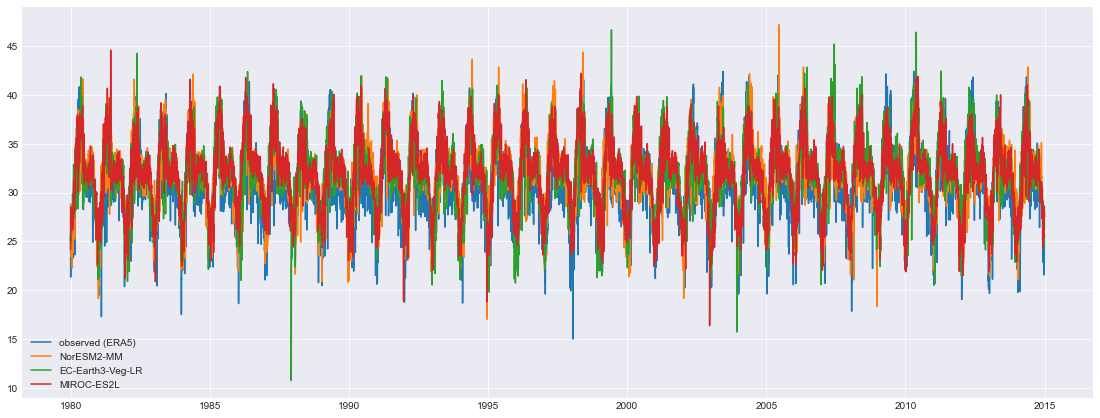

In [9]:
# Plot historical obs and modeled time series of tasmax

plt.figure(figsize=(6.4*3, 4.8*1.5))
plt.plot([1980 + (i/365) for i in range(365*35)], hist_obs-273.15, label='observed (ERA5)')
for model in hist_mod:
    plt.plot([1980 + (i/365) for i in range(365*35)], hist_mod[model]-273.15, label=model)
plt.xticks(ticks=[y for y in range(HIST_START, HIST_END+2) if y % 5 == 0])
plt.legend()
plt.show()

In [20]:
fut_mod = {}
for model in ['NorESM2-MM', 'EC-Earth3-Veg-LR', 'MIROC-ES2L']:
    fut_mod[model] = get_var('tasmax', model, INITIAL_LATLON, start_year=FUTURE_START, end_year=FUTURE_END)

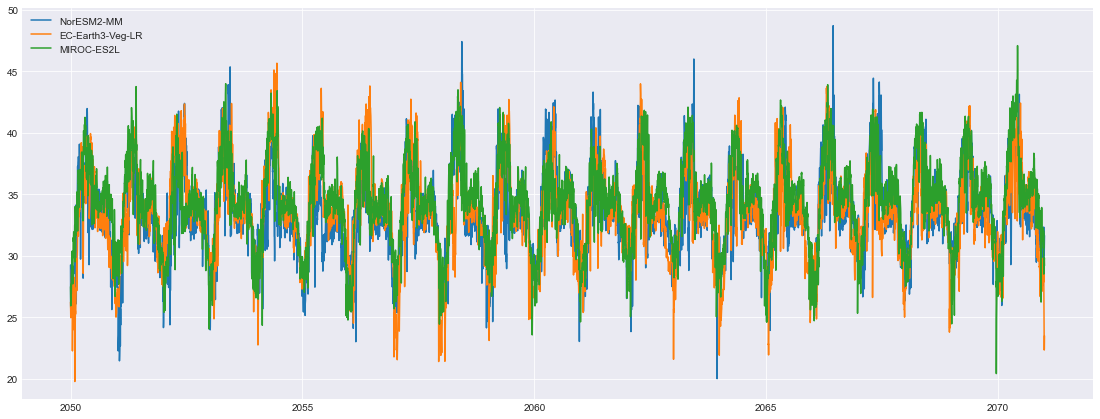

In [344]:
# Plot future modeled time series of tasmax

plt.figure(figsize=(6.4*3, 4.8*1.5))
for model in fut_mod:
    plt.plot([2050 + (i/365) for i in range(365*21)], fut_mod[model]-273.15, label=model)
plt.xticks(ticks=[y for y in range(FUTURE_START, FUTURE_END+1) if y % 5 == 0])
plt.legend()
plt.show()

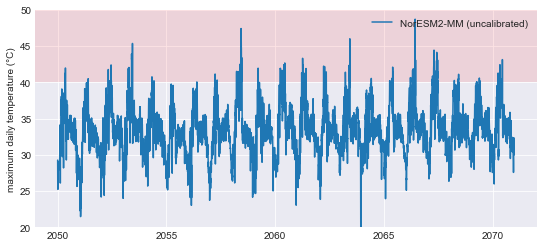

In [57]:
# Plot future modeled time series of UNCALIBRATED tasmax

plt.figure(figsize=(9, 4))
for model in list(fut_mod.keys())[:1]:
    plt.plot([2050 + (i/365) for i in range(365*21)], fut_mod[model]-273.15, label='{0} (uncalibrated)'.format(model))
    count = np.sum(np.sum((np.array(fut_mod[model])-273.15 >=40).reshape((FUTURE_END-FUTURE_START+1, 365)), axis=1)>=10)
plt.xticks(ticks=[y for y in range(FUTURE_START, FUTURE_END+1) if y % 5 == 0])
plt.ylim(20,50)
plt.axhspan(STUDY_THRESH, plt.axis()[3], facecolor='r', alpha=0.1)
plt.ylabel('maximum daily temperature (°C)')
#plt.text(2050, 45, '{0} days with max temp ≥ {1}C during 2050-2070 ({2} years with 10+ days)'.format(np.sum(fut_mod[model]-273.15 >= STUDY_THRESH), STUDY_THRESH, count), fontsize=30)
plt.legend(loc='upper right')
plt.show()

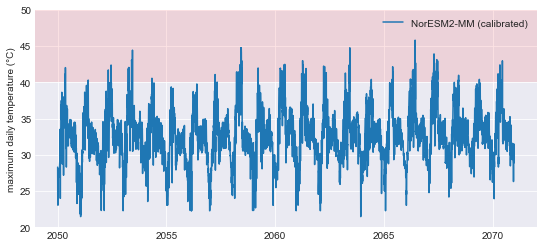

In [55]:
# Plot future modeled time series of CALIBRATED tasmax

plt.figure(figsize=(9,4))
for model in list(fut_mod.keys())[:1]:
    calib_data = np.array(calibrate(fut_mod[model]-273.15, calibration_fxn[model]))
    plt.plot([2050 + (i/365) for i in range(365*21)], calib_data, label='{0} (calibrated)'.format(model))
    count = np.sum(np.sum((np.array(calibrate(fut_mod[model], calibration_fxn[model]))-273.15 >=40).reshape((FUTURE_END-FUTURE_START+1, 365)), axis=1)>=10)
plt.xticks(ticks=[y for y in range(FUTURE_START, FUTURE_END+1) if y % 5 == 0])
plt.ylim(20,50)
plt.axhspan(STUDY_THRESH, plt.axis()[3], facecolor='r', alpha=0.1)
plt.ylabel('maximum daily temperature (°C)')
#plt.text(2050, 45, '{0} days with max temp ≥ {1}C during 2050-2070 ({2} years with 10+ days)'.format(np.sum(calib_data >= STUDY_THRESH), STUDY_THRESH, count), fontsize=30)
plt.legend()
plt.show()

In [95]:
for model in list(fut_mod.keys()):
    calib_data = np.array(calibrate(fut_mod[model]-273.15, calibration_fxn[model]))
    count = np.sum(np.sum((np.array(calibrate(fut_mod[model], calibration_fxn[model]))-273.15 >=40).reshape((FUTURE_END-FUTURE_START+1, 365)), axis=1)>=10)
    print(model, count)

NorESM2-MM 9
EC-Earth3-Veg-LR 11
MIROC-ES2L 13


In [32]:
def get_beta(count, num, size):
    return np.random.beta(a = count + 0.5, b = num - count + 0.5, size=size)

In [70]:
posterior_ps = {}
for model in fut_mod:
    count = np.sum(np.sum((np.array(calibrate(fut_mod[model], calibration_fxn[model]))-273.15 >=40).reshape((FUTURE_END-FUTURE_START+1, 365)), axis=1)>=10)
    posterior_ps[model] = get_beta(count, FUTURE_END - FUTURE_START + 1, 10000)

<Figure size 648x288 with 0 Axes>

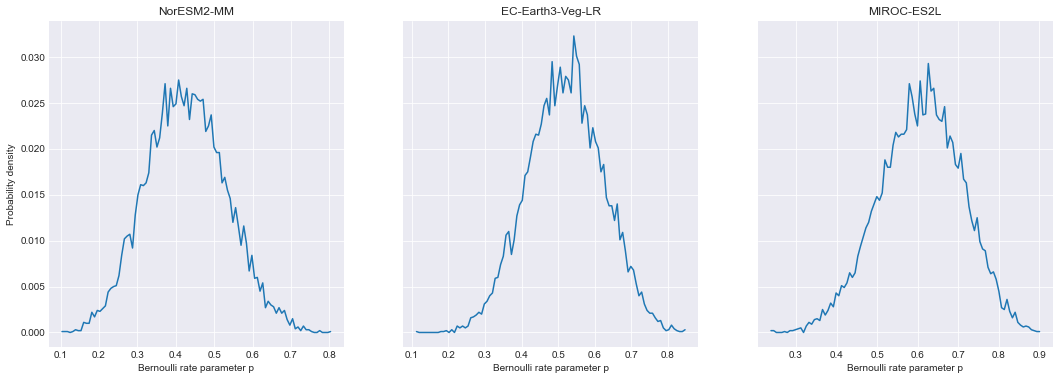

In [62]:
plt.figure(figsize=(9,4))
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, sharey=True, figsize=(18, 6))
hist = np.histogram(posterior_ps[list(posterior_ps.keys())[0]], bins=100)
hist0 = ax0.plot(hist[1][:-1], hist[0]/np.sum(hist[0]))
ax0.set_title(list(posterior_ps.keys())[0])
hist = np.histogram(posterior_ps[list(posterior_ps.keys())[1]], bins=100)
hist1 = ax1.plot(hist[1][:-1], hist[0]/np.sum(hist[0]))
ax1.set_title(list(posterior_ps.keys())[1])
hist = np.histogram(posterior_ps[list(posterior_ps.keys())[2]], bins=100)
hist2 = ax2.plot(hist[1][:-1], hist[0]/np.sum(hist[0]))
ax2.set_title(list(posterior_ps.keys())[2])
ax0.set_ylabel('Probability density')
ax0.set_xlabel('Bernoulli rate parameter p')
ax1.set_xlabel('Bernoulli rate parameter p')
ax2.set_xlabel('Bernoulli rate parameter p')
plt.show()

In [35]:
posterior_counts = {}
for model in posterior_ps:
    for n in range(365):
        posterior_counts[model] = np.random.binomial(FUTURE_END - FUTURE_START + 1, posterior_ps[model], 10000)

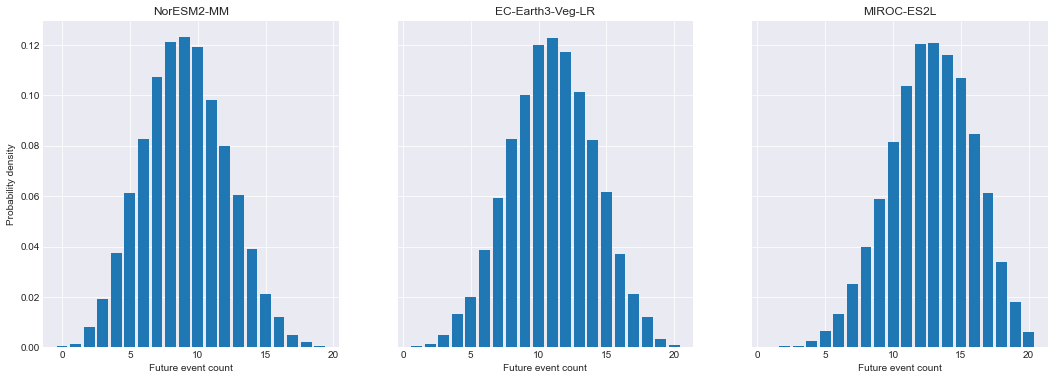

In [64]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, sharey=True, figsize=(18, 6))
hist = np.histogram(posterior_counts[list(posterior_counts.keys())[0]], bins=20)
hist0 = ax0.bar(hist[1][:-1], hist[0]/np.sum(hist[0]))
ax0.set_title(list(posterior_counts.keys())[0])
ax0.set_xticks([i for i in range(21) if i % 5 == 0])
hist = np.histogram(posterior_counts[list(posterior_counts.keys())[1]], bins=20)
hist1 = ax1.bar(hist[1][:-1], hist[0]/np.sum(hist[0]))
ax1.set_title(list(posterior_counts.keys())[1])
ax1.set_xticks([i for i in range(21) if i % 5 == 0])
hist = np.histogram(posterior_counts[list(posterior_counts.keys())[2]], bins=20)
hist2 = ax2.bar(hist[1][:-1], hist[0]/np.sum(hist[0]))
ax2.set_title(list(posterior_counts.keys())[2])
ax2.set_xticks([i for i in range(21) if i % 5 == 0])
ax0.set_ylabel('Probability density')
ax0.set_xlabel('Future event count')
ax1.set_xlabel('Future event count')
ax2.set_xlabel('Future event count')
plt.show()

In [59]:
hist

(array([   1,    6,    7,   26,   64,  132,  253,  399,  587,  813, 1038,
        1202, 1207, 1160, 1070,  846,  611,  338,  181,   59], dtype=int64),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21.]))

In [37]:
for model in posterior_counts:
    print('{0}: {1}'.format(model, np.sum(posterior_counts[model]) / 10000))

NorESM2-MM: 9.0664
EC-Earth3-Veg-LR: 10.9794
MIROC-ES2L: 12.8082
